# Игры — Формирование модели монетизации
 ###  Задача:

Сформировать модель монетизации игрового приложения.


### **Описание датасетов:**

Основной датасет содержит данные о событиях, совершенных в мобильной игре.

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Помимо основного датасета есть два датасета с информацией о рекламных активностях.

### План работы

1. Загрузка данных и подготовка их к анализу
 - проверка на наличие пропусков, дубликатов, соответсвие типа данных.


2. Исследовательский анализ данных: 
 - вычислить количество уникальных пользователей;
 - данные за какой период? найти максимальную и минимальную дату;
 - анализ распределения событий (event) и типов зданий (building_type);
 - сколько пользователей прошли/не прошли первый уровень;
 - анализ распределения количества событий building по каждому пользователю;
 - анализ распределения количества дней на завершение первого уровня по каждому пользователю;
 - анализ распределения построек по времени;
 - рассчитать Retention Rate, применяя когортный анализ;
 - анализ распределения затрат на рекламу;
 - анализ распределения пользователей по рекламным источникам;
 - рассчитать CAC.
 
 
3. Проанализировать влияние событий на совершение целевого события:
 - анализ среднего количества построек и доли завершивших первый уровень в разрезе источников;
 - анализ среднего количества построек (общее + по каждому виду), среднего времени прохождения первого уровня и среднего количества игровых дней в разрезе способа завершения первого уровня.
 

4. Проверить статистические гипотезы:

 - *Проверить гипотезу различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.*

 - *Проверить гипотезу различия количества построек между пользователями, которые пришли с facebook_ads, и пользователями, которые пришли с youtube_channel_reklama.*
 
 
5. Построить модель монетизации


6. Общие выводы и рекомендации
 
 
7. Подготовить презентацию
 
 
8. Сделать дашборд в Tableau:
 - Набор №1
    1. Построить диаграмму распределения количества построенных объектов
    2. Добавить индикатор количества пользователей
    3. Добавить фильтр дашборда по признаку завершения уровня
 - Набор №2
    1. Построить диаграмму, отображающую количество событий по дням
    2. Построить гистограмму, отображающую количество пользователей, пришедших из разных источников
    3. Добавить фильтр дашборда по типу события

## 1. Загрузка данных и подготовка их к анализу

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
import datetime
from scipy import stats as st
import plotly.io as pio
pio.renderers.default="plotly_mimetype+notebook_connected"

Загрузим файлы и сохраним их в переменные.

In [2]:
actions = pd.read_csv(r'C:\\actions.csv')
costs = pd.read_csv(r'C:\\costs.csv')
source = pd.read_csv(r'C:\\source.csv')

**Рассмотрим датасет game_actions.csv**

In [3]:
actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [4]:
actions.info() # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


In [5]:
actions.duplicated().sum() # проверка на дубликаты

1

Обнаружен 1 дубликат, удалим его.

In [6]:
actions.drop_duplicates(inplace=True) # удаление дубликатов
actions.reset_index(inplace=True, drop=True) # переиндексация

Изменим тип данных в столбце event_datetime.

In [7]:
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'])

Добавим столбец с датой

In [8]:
actions['date'] = actions['event_datetime'].dt.date

Есть пропущенные значения в столбцах building_type и project_type. Пропуски указывают на то, что пользователь в данном событии не реализовал проект (project_type) или не проходил задание (building_type). 

In [9]:
actions[actions['building_type'].isna()].head() # датасет с пропущенными значениями в столбце

,event_datetime,event,building_type,user_id,project_type,date
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN,2020-05-04
13134,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN,2020-05-05
15274,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN,2020-05-05
16284,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN,2020-05-05
19650,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN,2020-05-06


In [10]:
actions.building_type.unique() # уникальные значения столбца

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

In [11]:
actions.event.unique() # уникальные значения столбца

array(['building', 'finished_stage_1', 'project'], dtype=object)

In [12]:
actions.project_type.unique() # уникальные значения столбца

array([nan, 'satellite_orbital_assembly'], dtype=object)

**Рассмотрим датасет costs.csv**

In [13]:
costs

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


In [14]:
costs.info() # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


Изменим тип данных в столбце day.

In [15]:
costs['day'] = pd.to_datetime(costs['day'])

**Рассмотрим датасет source.csv**

In [16]:
source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [17]:
source.info() # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


In [18]:
source.source.unique() # уникальные значения столбца

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

Добавим к actions истоник трафика по каждому пользователю.

In [19]:
actions = actions.merge(source, how='left', on='user_id')

### Вывод по шагу №1 (Загрузка данных и подготовка их к анализу)

На данном этапе были загружены данные и проведена предварительная обработка данных.  
Удалены дубликаты (1 шт), пропущенных значений нет, изменен тип данных в столбцах с датой, добавлен столбец только с датой в датасет actions, столбец с источником. В целом данные представлены в хорошем качестве.

## 2. Исследовательский анализ данных

In [20]:
print('Количество уникальных пользователей: ', actions.user_id.nunique())
print('Начало периода таблицы actions: ', min(actions.event_datetime))
print('Конец периода таблицы actions: ', max(actions.event_datetime))
print('Начало периода таблицы costs: ', min(costs.day))
print('Конец периода таблицы costs: ', max(costs.day))

Количество уникальных пользователей:  13576
Начало периода таблицы actions:  2020-05-04 00:00:01
Конец периода таблицы actions:  2020-06-05 12:32:49
Начало периода таблицы costs:  2020-05-03 00:00:00
Конец периода таблицы costs:  2020-05-09 00:00:00


<font color="blue">Пользовательская когорта с 4 по 10 мая (13576 уникальных пользователя).  
Данные по событиям этих пользователей представлены с 4 мая по 5 июня.  
Рекламная компания с 3 по 9 мая.</font>

**Посмотрим на распределение событий (event) и типов зданий (building_type).**

Напишем функцию для построения графика.

In [21]:
def plotcount(data, column, name, dpi=None, indent=1000, rot=None):
    '''
    график countplot, аргументы:
    data - датасет, column - столбец, name - имя графика,
    dpi - разрешение, indent - отступ значений от столбца,
    rot - наклон подписей оси Х.
    '''
    fig = plt.figure(figsize=(6,3), dpi=dpi)
    ax = sns.countplot(x = column,
                      data = data,
                      order = data[column].value_counts().index,
                      palette=['#e1be8e', '#adc6e9', '#76d2db'])
    sns.despine(bottom=True)
    ax.set(xlabel=None)
    plt.xticks(rotation=rot)
    ax.set_title(name,
                 fontsize=13, color = '#344243', weight="bold", y=1.02)
    for i, count in enumerate(data[column].value_counts()):
        ax.text(i, count+indent, str(count) + ' (' + str(round(count/data[column].value_counts().sum()*100,2))+' %)',
                horizontalalignment='center', fontsize=10, color='black')
    plt.show()    

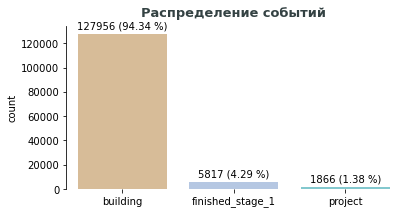

In [22]:
plotcount(actions, 'event', 'Распределение событий', indent=4000)

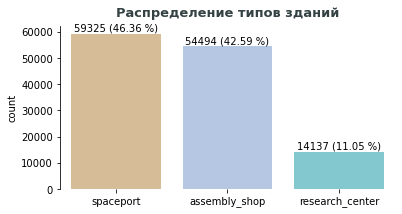

In [23]:
plotcount(actions, 'building_type', 'Распределение типов зданий')

<font color="blue">В основном все события (95%) это building (объект построен).  
Большинство строят spaceport (46%) и assembly_shop (43%), меньше построек research_center (11%).</font>

Для дальнейшего анализа сформируем новый датасет df.

In [24]:
df = pd.DataFrame(actions.user_id.unique())
df.columns = ['user_id']

Отметим пользователей которые прошли первый уровень.

In [25]:
finish_level = actions.query('event == "finished_stage_1"')['user_id'].unique()
df['finish_level'] = df['user_id'].apply(lambda x: 1 if x in finish_level else 0)

Разделим пользователей по способу прохождения первого уровня.

In [26]:
finish_level_project = actions.query('event == "project"')['user_id'].unique()

In [27]:
df['finish_level_split'] = df['user_id'].apply(lambda x: 'project' if x in finish_level_project
                                                         else 'victory' if x in finish_level
                                                         else 'no_finish')

Добавим количество событий building для каждого пользователя.

In [28]:
count_building = actions.query('event == "building"').groupby('user_id')\
                 .agg({'event':'count'}).reset_index().rename(columns={'event':'count_building'})
df = df.merge(count_building, how='left', on='user_id')

Добавим дату первого события для каждого пользователя.

In [29]:
first_day = actions.groupby('user_id')['date'].first().reset_index().rename(columns={'date':'first_day'})
df = df.merge(first_day, how='left', on='user_id')

Добавим дату завершения первого уровня.

In [30]:
finish_level_day = actions.query('event == "finished_stage_1"')[['user_id', 'date']].rename(columns={'date':'finish_level_day'})
df = df.merge(finish_level_day, how='left', on='user_id')

Добавим дату последнего события для каждого пользователя.

In [31]:
last_day = actions.groupby('user_id')['date'].last().reset_index().rename(columns={'date':'last_day'})
df = df.merge(last_day, how='left', on='user_id')

Вычислим время прохождения первого уровня в днях.

In [32]:
df['count_level_day'] = (df['finish_level_day']-df['first_day'])/datetime.timedelta(days=1)

Вычислим разницу между датами первого и последнего события.

In [33]:
df['total_day'] = (df['last_day']-df['first_day'])/datetime.timedelta(days=1)

Добавим количество дней в которые пользователи играли.

In [34]:
count_play_day = actions.groupby('user_id')['date'].nunique().reset_index().rename(columns={'date':'count_play_day'})
df = df.merge(count_play_day, how='left', on='user_id')

Добавим источник, с которого пришёл пользователь, установивший приложение.

In [35]:
df = df.merge(source, how='left', on='user_id')

Добавим количество построенных зданий каждым пользователем.

In [36]:
count_building_type = actions.groupby(['user_id', 'building_type'])['event_datetime'].count().reset_index()
count_building_type = count_building_type.pivot_table(index='user_id', columns='building_type', values='event_datetime').reset_index()
df = df.merge(count_building_type[['user_id','assembly_shop', 'spaceport', 'research_center']], how='left', on='user_id')

In [37]:
df.head()

,user_id,finish_level,finish_level_split,count_building,first_day,finish_level_day,last_day,count_level_day,total_day,count_play_day,source,assembly_shop,spaceport,research_center
0,55e92310-cb8e-4754-b622-597e124b03de,0,no_finish,7,2020-05-04,NaN,2020-05-10,NaN,6.0,5,youtube_channel_reklama,7.0,NaN,NaN
1,c07b1c10-f477-44dc-81dc-ec82254b1347,1,project,11,2020-05-04,2020-05-15,2020-05-15,11.0,11.0,10,facebook_ads,6.0,3.0,2.0
2,6edd42cc-e753-4ff6-a947-2107cd560710,1,victory,12,2020-05-04,2020-05-16,2020-05-16,12.0,12.0,10,instagram_new_adverts,6.0,4.0,2.0
3,92c69003-d60a-444a-827f-8cc51bf6bf4c,0,no_finish,10,2020-05-04,NaN,2020-05-12,NaN,8.0,5,facebook_ads,5.0,3.0,2.0
4,cdc6bb92-0ccb-4490-9866-ef142f09139d,1,victory,6,2020-05-04,2020-05-11,2020-05-11,7.0,7.0,5,yandex_direct,3.0,3.0,NaN


**Посмотрим сколько пользователей прошли/не прошли первый уровень.**

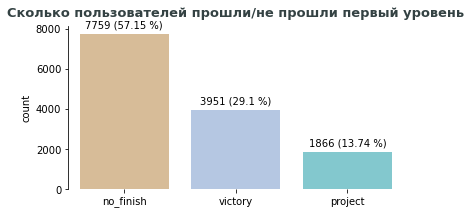

In [38]:
plotcount(df, 'finish_level_split', 'Сколько пользователей прошли/не прошли первый уровень', indent=300)

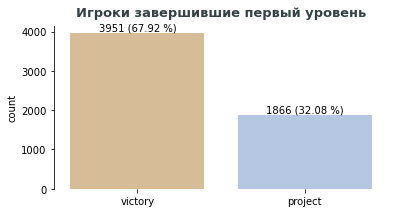

In [39]:
plotcount(df.query('finish_level == "1"'), 'finish_level_split', 'Игроки завершившие первый уровень', indent=80)

<font color="blue">57 % игроков не завершили первый уровень, 29 % завершили первый уровень победой над первым врагом, 13,7 % завершили первый уровень реализовав проект. Игроков-воинов в два раза больше игроков-строителей.</font>

**Посмотрим на распределение количества событий building по каждому пользователю.**

Напишем функцию для построения графика.

In [40]:
def plotly_hist(data, column, name, color=None):
    '''
    график histogram, аргументы:
    data - датасет, column - столбец, name - имя графика, color - деление на группы.
    '''
    fig = px.histogram(data, x=column, color=color, barmode='group', width=800, height=300)
    fig.data[0].marker.color = '#adc6e9' # цвет колонок
    fig.update_layout(
                      plot_bgcolor='#d9f2f5', # цвет фона
                      title=dict(text='<b>{}</b>'.format(name),
                                 font=dict(family="Arial",size=18,color='#344243'), x=0.5)
                      )
    fig.show()

In [41]:
plotly_hist(df, 'count_building', 'Распределение количества событий building по каждому пользователю')

<font color="blue">Среднее количество построек на игрока - 10-11. По графику виден провал на 7-ми постройках, возможно это легкий этап в игре и его быстро проходят. Этот этап игры можно эффективнее использовать для показа рекламы, т.к. если игрок построил 7 раз, то скорее всего построит и 8. </font>

**Посмотрим на распределение количества дней на завершение первого уровня по каждому пользователю.**

In [42]:
plotly_hist(df, 'count_level_day', 'Распределение количества дней на завершение первого уровня')

<font color="blue">В среднем первый уровень проходят за 10-12 дней. </font>

In [43]:
plotly_hist(df, 'count_play_day', 'Распределение количества игровых дней', color='finish_level')

<font color="blue">В среднем у игроков за представленный период было 7-9 игровых дня у завершивших первый уровень и 4-8 у пользователей, которые не прошли первый уровень.</font>

**Посмотрим на распределение построек по времени.**

In [44]:
count_building_type_day = actions.groupby(['date', 'building_type'])['user_id'].count().reset_index()\
                                 .rename(columns={'user_id':'count_building'})

In [45]:
palette = ['#76d2db', '#e1be8e', '#003b8d']
fig = px.line(count_building_type_day, x='date', y='count_building', color='building_type', width=800, height=400)
fig.update_layout(
                 plot_bgcolor='#d9f2f5', # цвет фона
                 title=dict(text='<b>Распределение построек по времени</b>',
                            font=dict(family="Arial",size=18,color='#344243'), x=0.5)
                 )
for i,c in zip(fig.data,palette):
    i.name = i.name[14:]
    i.line.color = c 
fig.show()

<font color="blue">По графику видно, что здание assembly_shop строится в начале игры и после семи дней его уже никто не строит. Также заметен спад количества построек после недели игры, возможно игроки перешли на следующий уровень или перестали играть.</font>

**Рассчитаем Retention Rate, применяя когортный анализ.**

Определим событие и период — на их основе сформируем когорту. Возьмём дату, когда пользователь впервые зашел в игру, период - 1 день. В датасете actions содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Для каждого пользователя получим дату его первого посещения.

In [46]:
actions['first_date'] = actions.groupby('user_id')['date'].transform('min')

Для каждой строки датафрейма рассчитаем lifetime пользователя в рамках когорты в неделях.

In [47]:
actions['cohort_lifetime'] = ((actions['date'] - actions['first_date'])
                                       /np.timedelta64(1,'W')).round().astype('int')

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённую неделю lifetime:

In [48]:
cohorts = actions.groupby(['first_date','cohort_lifetime'])['user_id'].nunique().reset_index()\
                 .rename(columns={'user_id':'count_users'})

Найдём исходное количество пользователей в когорте.

In [49]:
cohorts_size = cohorts[cohorts['cohort_lifetime'] == 0][['first_date','count_users']]\
               .rename(columns={'count_users':'cohort_users'})

Объединим данные по когортам с исходным количеством пользователей в когорте.

In [50]:
cohorts = cohorts.merge(cohorts_size,on='first_date')

Вычислим retention.

In [51]:
cohorts['retention'] = cohorts['count_users']/cohorts['cohort_users'] 

Построим сводную таблицу и создадим тепловую карту.

In [52]:
retention_pivot = cohorts.pivot_table(index='first_date',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot.loc['mean'] = retention_pivot.mean()

In [53]:
retention_pivot

cohort_lifetime,0,1,2,3,4
first_date,,,,,
2020-05-04,1.0,0.983106,0.555802,0.071843,0.003413
2020-05-05,1.0,0.972330,0.495686,0.058018,0.003570
2020-05-06,1.0,0.947482,0.438549,0.056308,0.003249
2020-05-07,1.0,0.901713,0.418395,0.072137,0.009017
2020-05-08,1.0,0.886628,0.392442,0.047965,0.002907
2020-05-09,1.0,0.897727,0.400000,0.065909,0.002273
2020-05-10,1.0,0.907749,0.409594,0.047970,NaN
mean,1.0,0.928105,0.444353,0.060022,0.004071


<AxesSubplot:title={'center':'Cohorts: User Retention'}, xlabel='cohort_lifetime', ylabel='first_date'>

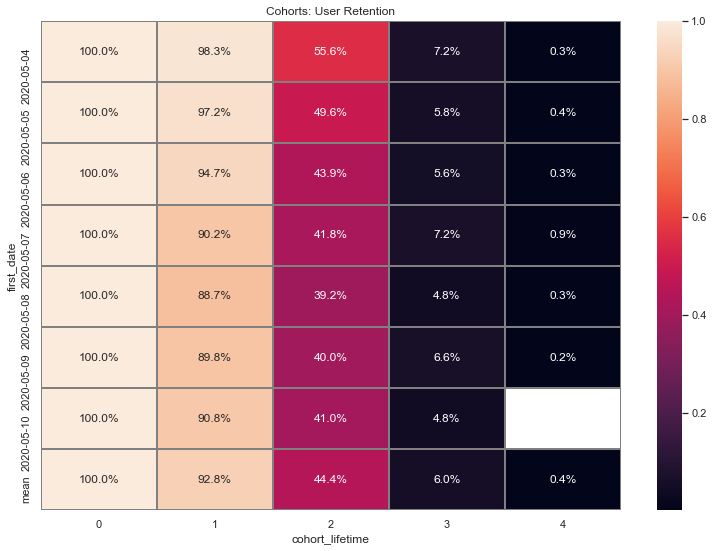

In [54]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

<font color="blue">На третью неделю "жизни" когорт Retention Rate равен 44,4%, далее идет резкий спад до 6% - это может быть обусловлено переходом пользователей на новый уровень либо прекращением активности. Можно выделить первую когорту, пользователи которой первый раз зашли в игру 4 мая 2020 г., в ней Retention снижается медленнее чем у остальных когорт.</font>

**Рассчитаем Retention Rate в разрезе источников рекламы.**

In [55]:
cohorts_source = actions.groupby(['source','cohort_lifetime'])['user_id'].nunique().reset_index()\
                 .rename(columns={'user_id':'count_users'})
cohorts_size_source = cohorts_source[cohorts_source['cohort_lifetime'] == 0][['source','count_users']]\
               .rename(columns={'count_users':'cohort_users'})
cohorts_source = cohorts_source.merge(cohorts_size_source,on='source')
cohorts_source['retention'] = cohorts_source['count_users']/cohorts_source['cohort_users']
retention_pivot_source = cohorts_source.pivot_table(index='source',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot_source.loc['mean'] = retention_pivot_source.mean()

In [56]:
retention_pivot_source

cohort_lifetime,0,1,2,3,4
source,,,,,
facebook_ads,1.0,0.962583,0.502201,0.067865,0.004402
instagram_new_adverts,1.0,0.965641,0.510009,0.064834,0.003884
yandex_direct,1.0,0.957858,0.484949,0.062487,0.003944
youtube_channel_reklama,1.0,0.953090,0.499628,0.064036,0.002606
mean,1.0,0.959793,0.499197,0.064805,0.003709


<AxesSubplot:title={'center':'Cohorts: User Retention'}, xlabel='cohort_lifetime', ylabel='source'>

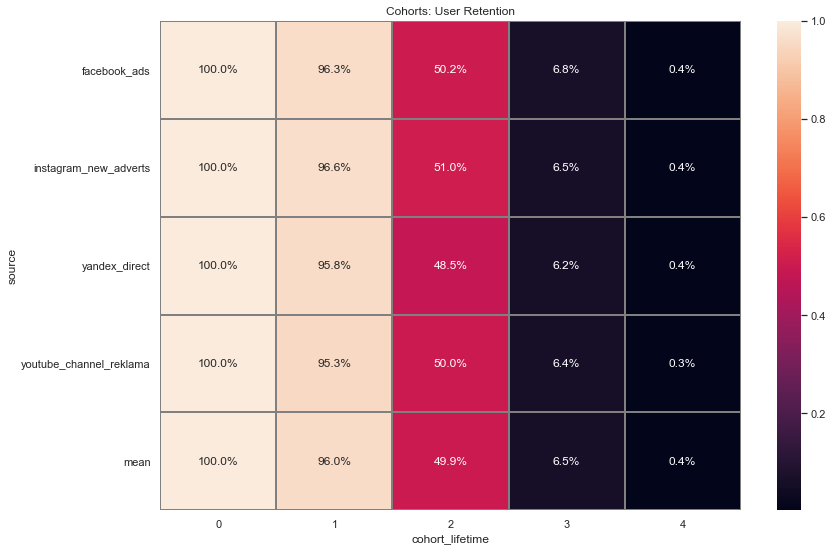

In [57]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot_source, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

<font color="blue">Отток игроков не зависит от источника рекламы, с которого пришел пользователь.</font>

**Посмотрим на распределение затрат на рекламу.**

In [58]:
source_sum = costs.groupby('source')['cost'].sum().reset_index().sort_values('cost', ascending=False)
source_sum['part,%'] = source_sum['cost']/source_sum.cost.sum()*100
source_sum = round(source_sum,1)

In [59]:
fig = px.bar(source_sum, x='source', y='cost', text='source', width=800, height=400)
fig.update_layout(
                 plot_bgcolor='#d9f2f5', # цвет фона
                 title=dict(text='<b>Распределение затрат по каждому источнику</b>',
                            font=dict(family="Arial",size=18,color='#344243'), x=0.5)
                 )
fig.data[0].marker.color = ['#e1be8e', '#adc6e9', '#76d2db', '#003b8d']
fig.data[0].text = [str(i)+' ('+str(c)+' %)' for i,c in zip(source_sum['cost'], source_sum['part,%'])]
fig.show()

In [60]:
fig = px.bar(costs, x='day', y='cost', color='source', barmode='group', width=800, height=400)
fig.update_layout(
                 plot_bgcolor='#d9f2f5', # цвет фона
                 title=dict(text='<b>Распределение затрат на рекламу по времени в разрезе источников </b>',
                            font=dict(family="Arial",size=18,color='#344243'), x=0.5)
                 )
for i,c in zip(fig.data,['#76d2db', '#adc6e9', '#e1be8e', '#003b8d']):
    i.name = i.name[7:]
    i.marker.color = c
fig.show()

<b>Общее распределение затрат на рекламу по времени</b>

In [61]:
costs_sum = costs.groupby('day')['cost'].sum().reset_index().sort_values('day')
costs_sum['part,%'] = costs_sum['cost']/costs_sum.cost.sum()*100
costs_sum = round(costs_sum,1)

In [62]:
costs_sum.style.bar(subset=['cost'], color='#adc6e9')\
                 .background_gradient(subset=['part,%'], cmap='Purples')

,day,cost,"part,%"
0,2020-05-03 00:00:00,3302.500000,43.400000
1,2020-05-04 00:00:00,1865.000000,24.500000
2,2020-05-05 00:00:00,1029.400000,13.500000
3,2020-05-06 00:00:00,620.500000,8.200000
4,2020-05-07 00:00:00,391.900000,5.200000
5,2020-05-08 00:00:00,242.800000,3.200000
6,2020-05-09 00:00:00,151.600000,2.000000


<font color="blue">Затраты на рекламу по источникам yandex, instagram, facebook одинаковые (по 28-29 %), на youtube потратили меньше всего 14 %.   
43 % всего рекламного бюджета было потрачено в первый день из семи, и далее траты распределяются по дням со снижением до 2 %.</font>

**Посмотрим на распределение пользователей по рекламным источникам.**

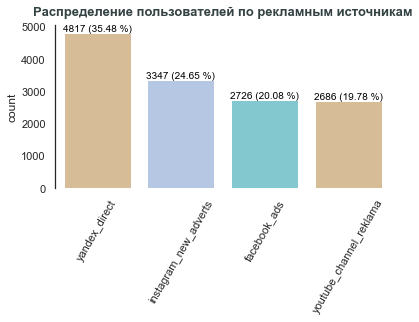

In [63]:
plotcount(source, 'source', 'Распределение пользователей по рекламным источникам', indent=50, rot=60)

<font color="blue">Больше всего пришло пользователей с yandex_direct (35%), c остальных источников по 20-25 %.</font>

**Рассичтаем CAC (стоимость привлечения клиента).**

In [64]:
cac = source.groupby('source')['user_id'].count().reset_index()
cac = cac.merge(source_sum[['source','cost']], on='source')
cac['cac'] = round(cac['cost']/cac['user_id'],2)
cac = cac.sort_values('cac')

In [65]:
cac.style.background_gradient(subset=['cac'], cmap='Purples')

,source,user_id,cost,cac
3,youtube_channel_reklama,2686,1068.100000,0.400000
2,yandex_direct,4817,2233.100000,0.460000
1,instagram_new_adverts,3347,2161.400000,0.650000
0,facebook_ads,2726,2140.900000,0.790000


<font color="blue">Дороже всего обходятся пользователи с источников  facebook_ads (cac=0.79) и instagram_new_adverts (0.65), самые "дешевые" игроки с youtube_channel_reklama (0.4).</font>

### Вывод по шагу №2 (Исследовательский анализ данных)

Пользовательская когорта с 4 по 10 мая (13576 уникальных пользователя).  
Данные по событиям этих пользователей представлены с 4 мая по 5 июня.  
Рекламная компания с 3 по 9 мая.

В основном все события (95%) это building (объект построен).  
Большинство строят spaceport (46%) и assembly_shop (43%), меньше построек research_center (11%).

57 % игроков не завершили первый уровень, 29 % завершили первый уровень победой над первым врагом, 13,7 % завершили первый уровень реализовав проект. Игроков-воинов в два раза больше игроков-строителей.

Среднее количество построек на игрока - 10-11. По графику виден провал на 7-ми постройках, возможно это легкий этап в игре и его быстро проходят. Этот этап игры можно эффективнее использовать для показа рекламы, т.к. если игрок построил 7 раз, то скорее всего построит и 8.

В среднем первый уровень проходят за 10-12 дней.

В среднем у игроков за представленный период было 7-9 игровых дня у завершивших первый уровень и 4-8 у пользователей, которые не прошли первый уровень.

По графику видно, что здание assembly_shop строится в начале игры и после семи дней его уже никто не строит. Также заметен спад количества построек после недели игры, возможно игроки перешли на следующий уровень или перестали играть.

На третью неделю "жизни" когорт Retention Rate равен 44,4%, далее идет резкий спад до 6% - это может быть обусловлено переходом пользователей на новый уровень либо прекращением активности. Можно выделить первую когорту, пользователи которой первый раз зашли в игру 4 мая 2020 г., в ней Retention снижается медленнее чем у остальных когорт.

Отток игроков не зависит от источника рекламы, с которого пришел пользователь.

Затраты на рекламу по источникам yandex, instagram, facebook одинаковые (по 28-29 %), на youtube потратили меньше всего 14 %.  
43 % всего рекламного бюджета было потрачено в первый день из семи, и далее траты распределяются по дням со снижением до 2 %.

Больше всего пришло пользователей с yandex_direct (35%), c остальных источников по 20-25 %.

Дороже всего обходятся пользователи с источников facebook_ads (cac=0.79) и instagram_new_adverts (0.65), самые "дешевые" игроки с youtube_channel_reklama (0.4).

## 3. Анализ влияния событий на совершение целевого события

Целевое событие - завершение первого уровня пользователем.

**Посмотрим на среднее количество построек и долю завершивших первый уровень в разрезе источников.**

In [66]:
df.groupby(['source']).agg({'user_id':'count','count_building':'mean', 'finish_level':'mean'})

,user_id,count_building,finish_level
source,,,
facebook_ads,2726,9.585840,0.421864
instagram_new_adverts,3347,9.505527,0.438004
yandex_direct,4817,9.348557,0.423915
youtube_channel_reklama,2686,9.299330,0.431497


<font color="blue">Среднее количество построек (9.3-9.6) и доля завершивших первый уровень (0.42-0.44) в разрезе источников,  с которого пришёл пользователь примерно одинаковая. </font>

**Посмотрим на среднее количество построек (общее + по каждому виду), среднее время прохождения первого уровня и среднее количество игровых дней в разрезе способа завершения первого уровня.**

In [67]:
df.groupby(['finish_level_split']).agg({'user_id':'count','count_building':'mean',
                                        'count_level_day':'mean', 'count_play_day':'mean',
                                        'assembly_shop':'mean', 'spaceport':'mean', 'research_center':'mean'})

,user_id,count_building,count_level_day,count_play_day,assembly_shop,spaceport,research_center
finish_level_split,,,,,,,
no_finish,7759,8.657043,NaN,6.239850,3.747906,4.203587,1.930407
project,1866,12.647910,13.396570,9.635584,4.885316,5.781350,1.981243
victory,3951,9.411541,11.058466,7.290812,4.125032,4.399589,1.603330


<font color="blue">В среднем, завершившие первый уровень проектом, проходят уровень на 2 дня дольше (13,4), чем игроки, победившие врага (11), также они больше строят и больше времени проводят в игре.</font>

### Вывод по шагу №3 (Анализ влияния событий на совершение целевого события)

Среднее количество построек (9.3-9.6) и доля завершивших первый уровень (0.42-0.44) в разрезе источников, с которого пришёл пользователь примерно одинаковая.

В среднем, завершившие первый уровень проектом, проходят уровень на 2 дня дольше (13,4), чем игроки, победившие врага (11), также они больше строят и больше времени проводят в игре.

## 4. Проверка статистических гипотез

**Проверим гипотезу различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.**

- H0 - различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком нет
- H1 - различие времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком есть

In [68]:
project = df.query('finish_level_split=="project"')['count_level_day']
victory = df.query('finish_level_split=="victory"')['count_level_day']

Гипотезы будем проверять через T-критерий Стьюдента.

Перед проведением проверки гипотез через T-критерий Стьюдента нужно сравнить дисперсии двух выборок отдельно, и если они различаются более чем на 5%, то считаем отличие значимым и выбираем параметр теста equal_var = False.

In [69]:
print('Дисперсии отличаются на ',round((100 - np.var(project, ddof=1)/np.var(victory, ddof=1)*100),2), ' %')

Дисперсии отличаются на  26.36  %


Выбираем equal_var = False

In [70]:
alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(project, victory, equal_var = False)
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, различие между пользователями есть")
else:
    print("Не получилось отвергнуть нулевую гипотезу, различия между пользователями нет")

p-значение:  6.570466755643636e-105
Отвергаем нулевую гипотезу, различие между пользователями есть


<font color="blue">Гипотеза подтверждена, различие есть. В среднем, пользователи завершившие первый уровень проектом, проходят уровень на 2 дня дольше (13,4), чем игроки, победившие врага (11).</font>

**Проверим гипотезу различия количества построек между пользователями, которые пришли с facebook_ads, и пользователями, которые пришли с  youtube_channel_reklama.**

- H0 - различия количества построек между пользователями, которые пришли с facebook_ads, и пользователями, которые пришли с youtube_channel_reklama нет
- H1 -различие количества построек между пользователями, которые пришли с facebook_ads, и пользователями, которые пришли с youtube_channel_reklama есть

In [71]:
facebook_ads = df.query('source=="facebook_ads"')['count_building']
youtube_channel_reklama = df.query('source=="youtube_channel_reklama"')['count_building']

In [72]:
print('Дисперсии отличаются на ',round((100 - np.var(facebook_ads, ddof=1)/np.var(youtube_channel_reklama, ddof=1)*100),2), ' %')

Дисперсии отличаются на  0.83  %


Выбираем equal_var = True

In [73]:
alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(facebook_ads, youtube_channel_reklama)
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, различие между пользователями есть")
else:
    print("Не получилось отвергнуть нулевую гипотезу, различия между пользователями нет")

p-значение:  0.006588846148210501
Отвергаем нулевую гипотезу, различие между пользователями есть


<font color="blue">Гипотеза подтверждена, различие есть. В среднем, пользователи, которые пришли с facebook_ads строят больше (9.6 построек) чем пользователи, которые пришли с youtube_channel_reklama (9.3 построек).</font>

### Вывод по шагу №4 (Проверка статистических гипотез)

Предложенные гипотезы подтверждены, есть статически-значимые различия. 

В среднем, пользователи завершившие первый уровень проектом, проходят уровень на 2 дня дольше (13,4), чем игроки, победившие врага (11).

В среднем, пользователи, которые пришли с facebook_ads строят больше (9.6 построек) чем пользователи, которые пришли с youtube_channel_reklama (9.3 построек).

## 5. Построение модели монетизации

In [74]:
n_users = actions.user_id.nunique()
print('Всего привлечено пользователей: ', n_users)
sum_costs = round(costs.cost.sum(),2)
cac_user = round(sum_costs/n_users,2)
print('Общие затраты на привлечение пользователей: ', sum_costs)
print('Средняя стоимость привлечение одного пользователя: ', cac_user)
print('Естественный отток игроков (без показа рекламы) к концу второй недели: ', round(retention_pivot_source[2][-1]*100), '%')

Всего привлечено пользователей:  13576
Общие затраты на привлечение пользователей:  7603.58
Средняя стоимость привлечение одного пользователя:  0.56
Естественный отток игроков (без показа рекламы) к концу второй недели:  50 %


Напишем функцию для расчета модели.

In [75]:
def monetization_model(count_event, outflow, total_сosts):
    '''
    модель рассчитывает минимальную стоимость показа рекламы, аргументы:
    count_event - количество событий, outflow - процент дополнительного оттока пользователей,
    total_сosts - затраты на привлечение пользователей.
    '''
    print('Минимальная стоимость показа, чтобы выйти на окупаемость: ',
          round(total_сosts/(count_event*(1-outflow/100)),4))
    print('Возможный дополнительный отток пользователей из-за рекламы (снижение количества построек): ', outflow, '%')

**1 вариант:**
 - показывать рекламу во всех событиях с экраном выбором постройки;
 - предположим, что количество построек из-за рекламы снизится на 30 %;
 - затраты на привлечение новых пользователей оставим без изменений.

In [76]:
count_event_1 = df.count_building.sum()

In [77]:
monetization_model(count_event_1, 30, sum_costs)

Минимальная стоимость показа, чтобы выйти на окупаемость:  0.0849
Возможный дополнительный отток пользователей из-за рекламы (снижение количества построек):  30 %


**2 вариант:**
 - показывать рекламу начиная с 8 постройки, когда пользователь уже втянется в игру;
 - предположим, что количество построек из-за рекламы снизится на 5 %;
 - затраты на привлечение новых пользователей оставим без изменений.

In [78]:
df['count_event_2'] = df['count_building']-7
count_event_2 = df[df['count_event_2']>0]['count_event_2'].sum()

In [79]:
monetization_model(count_event_2, 5, sum_costs)

Минимальная стоимость показа, чтобы выйти на окупаемость:  0.1882
Возможный дополнительный отток пользователей из-за рекламы (снижение количества построек):  5 %


**3 вариант:**
 - показывать рекламу на всех событиях;
 - предположим, что количество построек из-за рекламы снизится на 40 %;
 - привлекать пользователей будем только с самого выгодного источника youtube_channel_reklama.

In [80]:
count_event_3 = len(actions)
sum_costs_3 = n_users*0.4 # cac youtube_channel_reklama = 0.4

In [81]:
monetization_model(count_event_3, 40, sum_costs_3)

Минимальная стоимость показа, чтобы выйти на окупаемость:  0.0667
Возможный дополнительный отток пользователей из-за рекламы (снижение количества построек):  40 %


### Вывод по шагу №5 (Построение модели монетизации)

На данном этапе были просчитаны 3 модели монетизации, самая лучшая из них имеет следующие параметры:

**3 вариант:**
 - показ рекламы на всех событиях;
 - предположим, что количество построек из-за рекламы снизится на 40 %;
 - привлекать пользователей только с самого выгодного источника youtube_channel_reklama.

In [82]:
monetization_model(count_event_3, 40, sum_costs_3)

Минимальная стоимость показа, чтобы выйти на окупаемость:  0.0667
Возможный дополнительный отток пользователей из-за рекламы (снижение количества построек):  40 %


## 6. Общие выводы и рекомендации

- В датасетах содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.Всего 13576 уникальных пользователя. Данные по событиям этих пользователей представлены с 4 мая по 5 июня.  
- Рекламная компания проводилась с 3 по 9 мая.
- В основном все события (95%) это building (объект построен).  
- Большинство строят spaceport (46%) и assembly_shop (43%), меньше построек research_center (11%).
- 57 % игроков не завершили первый уровень, 29 % завершили первый уровень победой над первым врагом, 13,7 % завершили первый уровень реализовав проект.
- Игроков-воинов в два раза больше игроков-строителей.
- Среднее количество построек на игрока - 10-11. Есть провал в распределении на 7-ми постройках, возможно это легкий этап в игре и его быстро проходят. Этот этап игры можно эффективнее использовать для показа рекламы, т.к. если игрок построил 7 раз, то скорее всего построит и 8.
- В среднем первый уровень проходят за 10-12 дней.
- В среднем у игроков за представленный период было 7-9 игровых дня у завершивших первый уровень и 4-8 у пользователей, которые не прошли первый уровень.
- Здание assembly_shop строится в начале игры и после семи дней его уже никто не строит. Также заметен спад количества построек после недели игры, возможно игроки перешли на следующий уровень или перестали играть.
- На третью неделю "жизни" когорт Retention Rate равен 44,4%, далее идет резкий спад до 6% - это может быть обусловлено переходом пользователей на новый уровень либо прекращением активности. Можно выделить первую когорту, пользователи которой первый раз зашли в игру 4 мая 2020 г., в ней Retention снижается медленнее чем у остальных когорт.
- Отток игроков не зависит от источника рекламы, с которого пришел пользователь.
- Затраты на рекламу по источникам yandex, instagram, facebook одинаковые (по 28-29 %), на youtube потратили меньше всего 14 %.  
- 43 % всего рекламного бюджета было потрачено в первый день из семи, и далее траты распределяются по дням со снижением до 2 %.
- Больше всего пришло пользователей с yandex_direct (35%), c остальных источников по 20-25 %.
- Дороже всего обходятся пользователи с источников facebook_ads (cac=0.79) и instagram_new_adverts (0.65), самые "дешевые" игроки с youtube_channel_reklama (0.4).
- Среднее количество построек (9.3-9.6) и доля завершивших первый уровень (0.42-0.44) в разрезе источников, с которого пришёл пользователь примерно одинаковая.
- В среднем, завершившие первый уровень проектом, проходят уровень на 2 дня дольше (13,4), чем игроки, победившие врага (11), также они больше строят и больше времени проводят в игре.

Гипотеза различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком **подтверждена, различие есть. В среднем, пользователи завершившие первый уровень проектом, проходят уровень на 2 дня дольше (13,4), чем игроки, победившие врага (11).**

Гипотеза различия количества построек между пользователями, которые пришли с facebook_ads, и пользователями, которые пришли с youtube_channel_reklama  **подтверждена, различие есть. В среднем, пользователи, которые пришли с facebook_ads строят больше (9.6 построек) чем пользователи, которые пришли с youtube_channel_reklama (9.3 построек).**

**Просчитаны 3 модели монетизации, самая лучшая из них имеет следующие параметры:**

**3 вариант:**
 - показ рекламы на всех событиях;
 - предположим, что количество построек из-за рекламы снизится на 40 %;
 - привлекать пользователей только с самого выгодного источника youtube_channel_reklama.

В итоге по этой модели получается:
 - Минимальная стоимость показа, чтобы выйти на окупаемость:  0.0667
 - Возможный дополнительный отток пользователей из-за рекламы (снижение количества построек):  40 %

**Дополнительные рекомендации по модели монетизации игрового приложения:**
- представленная когорта должна вернуть не меньше затраченных на ее привлечение средств (7603);
- рекламу лучше показывать за бонус в игре;
- за рекламу не должно быть стыдно;
- перед 8 постройкой можно показывать дорогую видео-рекламу, т.к. вероятнее всего игрок продолжит строительство дальше;
- необходимо предусмотреть возможность отключения рекламы за плату;
- также стоит пересмотреть затраты на маркетинг, акцент следует сделать на youtube_channel_reklama;
- игроков-воинов в два раза больше игроков-строителей, возможно стоит пересмотреть запланированное место показа рекламы на экране выбора постройки.

## 7. Презентация

https://disk.yandex.ru/i/i75seVUepmqX1A

## 8. Дашборд в Tableau

https://public.tableau.com/views/Book1_16184820681390/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link